## 0) Load & column auto-detect

In [52]:
import pandas as pd, re, numpy as np, random
RANDOM_SEED = 42
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

CSV_PATH = "bike_rental_reviews.csv"  # ← your single path

TEXT_COL_OVERRIDE  = None
LABEL_COL_OVERRIDE = None

_TEXT = ["review_text","review","text","content","comment","message","body","description"]
_LABEL = ["sentiment","label","rating","target","polarity","class"]

def _norm(s): return re.sub(r"[^a-z0-9]", "", s.lower())
def detect_columns(df, t_override=None, y_override=None):
    cols = list(df.columns); m = {_norm(c): c for c in cols}
    t = m.get(_norm(t_override)) if t_override else next((m.get(_norm(c)) for c in _TEXT if _norm(c) in m), None)
    y = m.get(_norm(y_override)) if y_override else next((m.get(_norm(c)) for c in _LABEL if _norm(c) in m), None)
    if not t or not y or t == y:
        raise ValueError(f"Could not auto-detect both text & label. Columns={cols}. Set overrides if needed.")
    return t, y

df_full = pd.read_csv(CSV_PATH)
tcol, ycol = detect_columns(df_full, TEXT_COL_OVERRIDE, LABEL_COL_OVERRIDE)
df_raw = df_full[[tcol, ycol]].rename(columns={tcol:"text", ycol:"label"}).dropna()
df_raw["text"]  = df_raw["text"].astype(str).str.strip()
df_raw["label"] = df_raw["label"].astype(str).str.strip().str.lower()

print(f"Loaded {CSV_PATH} → {df_raw.shape} | text='{tcol}' label='{ycol}'")



Loaded bike_rental_reviews.csv → (50000, 2) | text='review_text' label='sentiment'


## 1) Quick EDA

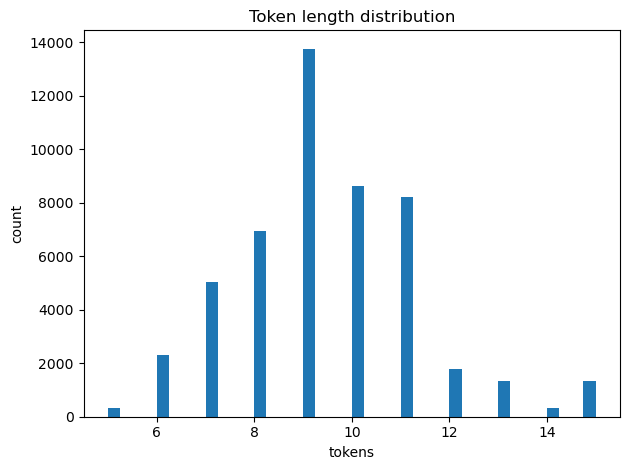

Token length summary: {'min': 5, 'median': 9, 'p95': 13, 'max': 15}


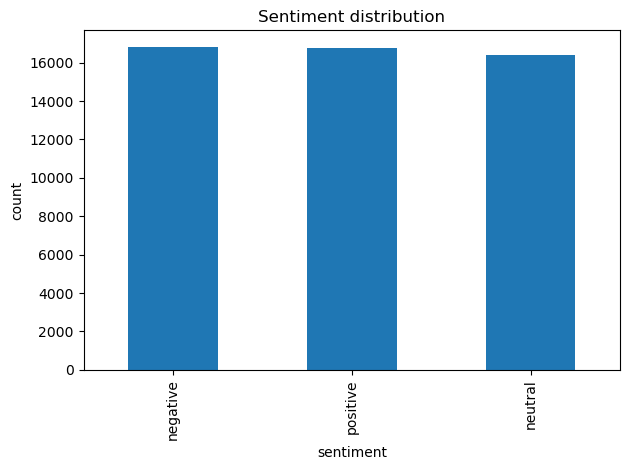

Label counts:
 negative    16840
positive    16777
neutral     16383


In [53]:
import matplotlib.pyplot as plt

# token length
lens = df_raw["text"].str.split().str.len().fillna(0).astype(int)
plt.figure(); plt.hist(lens, bins=40)
plt.title("Token length distribution"); plt.xlabel("tokens"); plt.ylabel("count")
plt.tight_layout(); plt.show()
print("Token length summary:",
      {"min": int(lens.min()), "median": int(lens.median()),
       "p95": int(lens.quantile(0.95)), "max": int(lens.max())})

# label distribution
counts = df_raw["label"].value_counts()
plt.figure(); counts.plot(kind="bar")
plt.title("Sentiment distribution"); plt.xlabel("sentiment"); plt.ylabel("count")
plt.tight_layout(); plt.show()
print("Label counts:\n", counts.to_string())


## 2) Preprocess & Vectorize + token previews

In [54]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

def basic_clean(s: str) -> str:
    s = s.lower()
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)         # URLs
    s = re.sub(r"[^a-z0-9'\s]", " ", s)                  # keep letters/digits/apostrophes
    s = re.sub(r"\s+", " ", s).strip()
    return s

tfidf_word = TfidfVectorizer(
    preprocessor=basic_clean, lowercase=False,
    stop_words="english", token_pattern=r"(?u)\b[a-z0-9][a-z0-9']+\b",
    ngram_range=(1,2), min_df=2, max_df=0.90
)
tfidf_char = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=2, max_df=0.90)

# visible tokenization using the same analyzer
analyzer = tfidf_word.build_analyzer()
print("Token previews:")
for i, s in enumerate(df_raw["text"].sample(n=min(5, len(df_raw)), random_state=RANDOM_SEED), 1):
    print(f"{i:02d}.", analyzer(s)[:40])

tok_counts = Counter()
for s in df_raw["text"]:
    tok_counts.update(analyzer(s))
print("\nTop 20 tokens overall:", tok_counts.most_common(20))
print("Unique token count:", len(tok_counts))


Token previews:
01. ['average', 'experience', 'seat', 'comfort', 'worked', 'expected', 'average experience', 'experience seat', 'seat comfort', 'comfort worked', 'worked expected']
02. ['pricing', 'disaster', 'disappointed', 'pricing disaster', 'disaster disappointed']
03. ['frustrating', 'process', 'battery', 'life', 'working', 'properly', 'frustrating process', 'process battery', 'battery life', 'life working', 'working properly']
04. ['absolutely', 'loved', 'mobile', 'app', 'experience', 'fantastic', 'absolutely loved', 'loved mobile', 'mobile app', 'app experience', 'experience fantastic']
05. ['superb', 'experience', 'renting', 'bikes', 'customer', 'service', 'outstanding', 'superb experience', 'experience renting', 'renting bikes', 'bikes customer', 'customer service', 'service outstanding']

Top 20 tokens overall: [('process', 11507), ('experience', 10061), ('rental', 9709), ('service', 8140), ('bikes', 6761), ('ride', 6650), ('condition', 6595), ('bike', 6533), ('decent', 4939)

## 3)-Train/Test Split & Baselines

In [55]:
# --- Grouped split by text content (prevents duplicate leakage) ---
from sklearn.model_selection import GroupShuffleSplit
import numpy as np, pandas as pd, hashlib

def _md5(x): return hashlib.md5(str(x).encode("utf-8")).hexdigest()
groups = df_raw["text"].str.strip().str.lower().map(_md5)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df_raw, groups=groups))

X_tr = df_raw.iloc[train_idx]["text"].values
y_tr = df_raw.iloc[train_idx]["label"].values
X_te = df_raw.iloc[test_idx]["text"].values
y_te = df_raw.iloc[test_idx]["label"].values

print(f"Grouped split → train={len(X_tr)}  test={len(X_te)}  (exact overlap now 0)")


Grouped split → train=39913  test=10087  (exact overlap now 0)


## 4) Traditional Baselines (LogReg & Naive Bayes)

Vectorizing features...
Vectorization complete. Training features shape: (39913, 3581)

--- Training Logistic Regression ---
### Logistic Regression Results (Best C=0.5) ###

Accuracy: 1.0000
Weighted F1-Score: 1.0000

**Classification Report:**
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      3296
     neutral       1.00      1.00      1.00      3609
    positive       1.00      1.00      1.00      3182

    accuracy                           1.00     10087
   macro avg       1.00      1.00      1.00     10087
weighted avg       1.00      1.00      1.00     10087



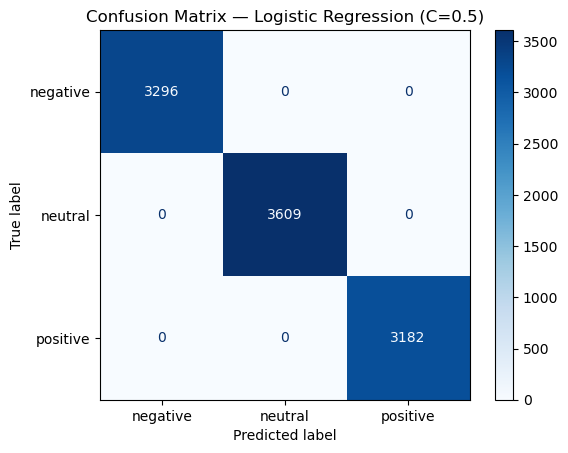


--- Training Multinomial Naïve Bayes ---
### Multinomial Naïve Bayes Results (Best α=0.01) ###

Accuracy: 1.0000
Weighted F1-Score: 1.0000

**Classification Report:**
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      3296
     neutral       1.00      1.00      1.00      3609
    positive       1.00      1.00      1.00      3182

    accuracy                           1.00     10087
   macro avg       1.00      1.00      1.00     10087
weighted avg       1.00      1.00      1.00     10087



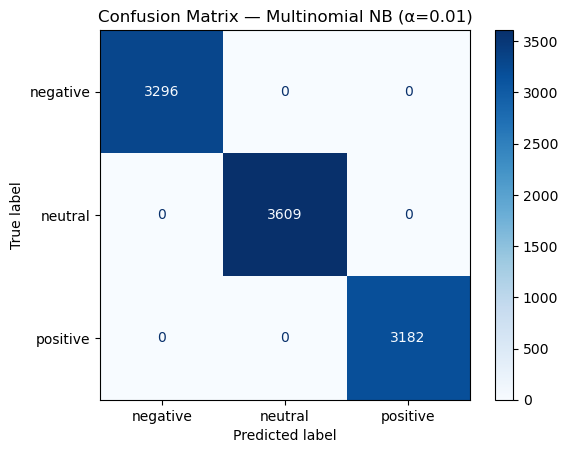

\nBest traditional baseline is Naïve Bayes with F1-score: 1.0000


In [56]:
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- 1. Feature Vectorization (TF-IDF) ---
# NOTE: This uses X_tr, X_te, etc., from the cell above.
# It fits the vectorizers ONLY on the training data to prevent data leakage.

print("Vectorizing features...")
tfidf_word = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,  
    max_df=0.9,
    preprocessor=basic_clean,
    stop_words="english",
    token_pattern=r"(?u)\b[a-z0-9][a-z0-9']+\b"
)
tfidf_char = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    min_df=2,  
    max_df=0.9
)

Xw_tr = tfidf_word.fit_transform(X_tr)
Xc_tr = tfidf_char.fit_transform(X_tr)
X_tr_sp = hstack([Xw_tr, Xc_tr])

Xw_te = tfidf_word.transform(X_te)
Xc_te = tfidf_char.transform(X_te)
X_te_sp = hstack([Xw_te, Xc_te])

print(f"Vectorization complete. Training features shape: {X_tr_sp.shape}\n")


# --- 2. Logistic Regression (with C Sweep) ---
print("--- Training Logistic Regression ---")
best_lr = None
best_lr_f1 = -1
best_lr_pred = None

for C in [0.5, 1.0, 2.0, 5.0]:
    lr = LogisticRegression(max_iter=500, class_weight="balanced", C=C, random_state=42, solver='liblinear')
    lr.fit(X_tr_sp, y_tr)
    pred = lr.predict(X_te_sp)
    f1 = f1_score(y_te, pred, average="weighted")
    if f1 > best_lr_f1:
        best_lr_f1 = f1
        best_lr = lr
        best_lr_pred = pred

# Evaluation
acc = accuracy_score(y_te, best_lr_pred)
print(f"### Logistic Regression Results (Best C={best_lr.C}) ###\n")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1-Score: {best_lr_f1:.4f}\n")
print("**Classification Report:**")
print(classification_report(y_te, best_lr_pred))

# Confusion Matrix
cm = confusion_matrix(y_te, best_lr_pred, labels=best_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix — Logistic Regression (C={best_lr.C})")
plt.show()


# --- 3. Multinomial Naïve Bayes (with α Sweep) ---
print("\n--- Training Multinomial Naïve Bayes ---")
best_nb = None
best_nb_f1 = -1
best_nb_pred = None

for alpha in [0.01, 0.1, 0.5, 1.0]:
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_tr_sp, y_tr)
    pred = nb.predict(X_te_sp)
    f1 = f1_score(y_te, pred, average="weighted")
    if f1 > best_nb_f1:
        best_nb_f1 = f1
        best_nb = nb
        best_nb_pred = pred

# Evaluation
acc = accuracy_score(y_te, best_nb_pred)
print(f"### Multinomial Naïve Bayes Results (Best α={best_nb.alpha}) ###\n")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1-Score: {best_nb_f1:.4f}\n")
print("**Classification Report:**")
print(classification_report(y_te, best_nb_pred))

# Confusion Matrix
cm = confusion_matrix(y_te, best_nb_pred, labels=best_nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_nb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix — Multinomial NB (α={best_nb.alpha})")
plt.show()
# --- 5. Determine and Announce the Best Baseline Model ---
if best_lr_f1 > best_nb_f1:
    best_name = "LogReg"
    best_model = best_lr
    print(f"\\nBest traditional baseline is Logistic Regression with F1-score: {best_lr_f1:.4f}")
else:
    best_name = "NaiveBayes"
    best_model = best_nb
    print(f"\\nBest traditional baseline is Naïve Bayes with F1-score: {best_nb_f1:.4f}")

## 5) Deep Learning: LSTM

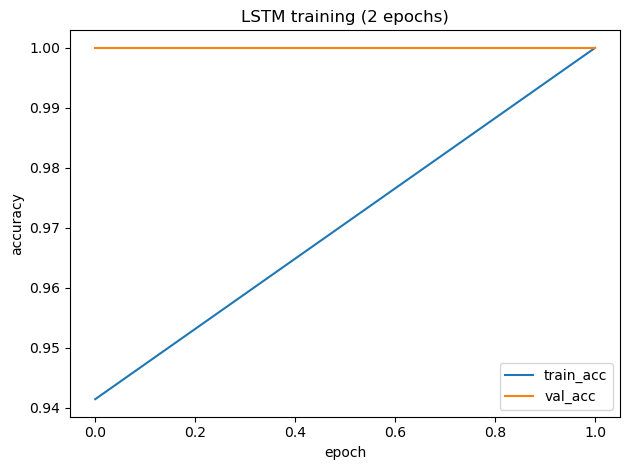

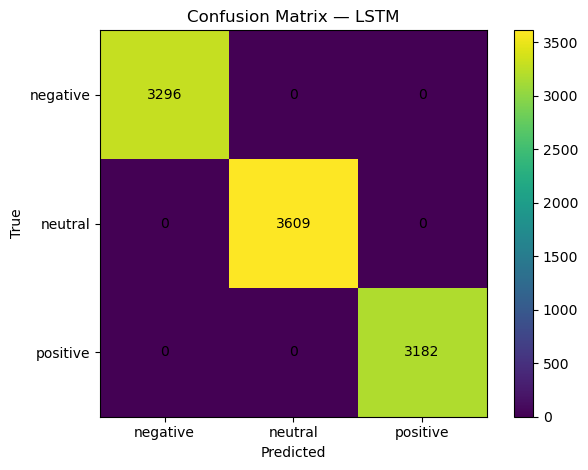

LSTM  Acc=1.0000  F1_w=1.0000
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      3296
     neutral       1.00      1.00      1.00      3609
    positive       1.00      1.00      1.00      3182

    accuracy                           1.00     10087
   macro avg       1.00      1.00      1.00     10087
weighted avg       1.00      1.00      1.00     10087



In [57]:
# ===== LSTM =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Reuse existing split if present; otherwise make one
try:
    X_tr, X_te, y_tr, y_te  # type: ignore
except NameError:
    from sklearn.model_selection import train_test_split
    X_tr, X_te, y_tr, y_te = train_test_split(
        df_raw["text"].values, df_raw["label"].values,
        test_size=0.2, random_state=42, stratify=df_raw["label"].values
    )

try:
    import tensorflow as tf
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras import layers, models

    tf.random.set_seed(42)

    # Tokenize -> pad
    tk = Tokenizer(num_words=20000, oov_token="<UNK>")
    tk.fit_on_texts(X_tr)
    seq_tr = pad_sequences(tk.texts_to_sequences(X_tr), maxlen=120)
    seq_te = pad_sequences(tk.texts_to_sequences(X_te), maxlen=120)

    # Label encoding
    classes = sorted(pd.Series(df_raw["label"]).unique())
    cls2id = {c:i for i,c in enumerate(classes)}
    y_tr_id = np.array([cls2id[y] for y in y_tr]); y_te_id = np.array([cls2id[y] for y in y_te])

    # Small model, 2 epochs
    model = models.Sequential([
        layers.Embedding(input_dim=20000, output_dim=64),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dense(len(classes), activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    hist = model.fit(seq_tr, y_tr_id, epochs=2, batch_size=256, validation_split=0.1, verbose=0)

    # Plot training curve (simple)
    plt.figure()
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.title("LSTM training (2 epochs)")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.tight_layout(); plt.show()

    # Predictions + Confusion Matrix
    pred_ids = model.predict(seq_te, verbose=0).argmax(axis=1)
    y_pred = [classes[i] for i in pred_ids]

    cm = confusion_matrix(y_te, y_pred, labels=classes)
    plt.figure()
    plt.imshow(cm); plt.colorbar()
    plt.xticks(range(len(classes)), classes); plt.yticks(range(len(classes)), classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — LSTM")
    plt.tight_layout(); plt.show()

    # Plain print report under the plots
    acc = accuracy_score(y_te, y_pred)
    f1w = f1_score(y_te, y_pred, average="weighted")
    print(f"LSTM  Acc={acc:.4f}  F1_w={f1w:.4f}")
    print(classification_report(y_te, y_pred))
except Exception as e:
    print("Skipping LSTM (TensorFlow not available or errored):", e)


## 6) Deep Learning: Transformer / BERT

/opt/anaconda3/envs/nlp-gensim/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


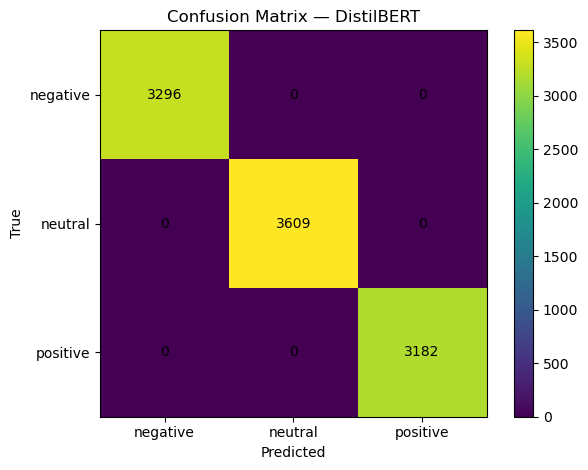

BERT  Acc=1.0000  F1_w=1.0000
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      3296
     neutral       1.00      1.00      1.00      3609
    positive       1.00      1.00      1.00      3182

    accuracy                           1.00     10087
   macro avg       1.00      1.00      1.00     10087
weighted avg       1.00      1.00      1.00     10087



In [58]:
# ===== Transformer (DistilBERT) — =====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.environ.setdefault("HF_HUB_DISABLE_TELEMETRY", "1")   # quiet HF
from transformers.utils import logging as hf_logging
hf_logging.set_verbosity_error()

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


# Reuse existing split if present; otherwise make one
try:
    X_tr, X_te, y_tr, y_te  # type: ignore
except NameError:
    from sklearn.model_selection import train_test_split
    X_tr, X_te, y_tr, y_te = train_test_split(
        df_raw["text"].values, df_raw["label"].values,
        test_size=0.2, random_state=42, stratify=df_raw["label"].values
    )

try:
    # Optional: quiet some HF telemetry
    os.environ.setdefault("HF_HUB_DISABLE_TELEMETRY", "1")

    import torch
    from torch.utils.data import Dataset, DataLoader
    from transformers import AutoTokenizer, AutoModelForSequenceClassification

    device = "cuda" if torch.cuda.is_available() else "cpu"
    classes = sorted(pd.Series(df_raw["label"]).unique())
    cls2id = {c:i for i,c in enumerate(classes)}

    model_name = "distilbert-base-uncased"
    tok = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes)).to(device)

    # Small subset & 1 epoch to keep things quick
    subset_n = min(3000, len(X_tr))
    idx = np.random.default_rng(42).choice(len(X_tr), size=subset_n, replace=False)
    X_sub = [str(X_tr[i]) for i in idx]
    y_sub = [cls2id[y_tr[i]] for i in idx]

    class DS(Dataset):
        def __init__(self, texts, labels):
            self.texts = texts; self.labels = labels
        def __len__(self): return len(self.texts)
        def __getitem__(self, i):
            enc = tok(self.texts[i], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
            item = {k:v.squeeze(0) for k,v in enc.items()}
            item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
            return item

    train_loader = DataLoader(DS(X_sub, y_sub), batch_size=16, shuffle=True)
    optim = torch.optim.AdamW(model.parameters(), lr=2e-5)

    model.train()
    for batch in train_loader:
        for k in batch: batch[k] = batch[k].to(device)
        out = model(**batch)
        out.loss.backward(); optim.step(); optim.zero_grad()
    # (one short epoch)

    # Evaluate on test
    model.eval()
    preds = []
    with torch.no_grad():
        for x in X_te:
            enc = tok(str(x), truncation=True, padding="max_length", max_length=128, return_tensors="pt").to(device)
            p = model(**enc).logits.argmax(dim=1).item()
            preds.append(classes[p])

    # Confusion Matrix
    cm = confusion_matrix(y_te, preds, labels=classes)
    plt.figure()
    plt.imshow(cm); plt.colorbar()
    plt.xticks(range(len(classes)), classes); plt.yticks(range(len(classes)), classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — DistilBERT")
    plt.tight_layout(); plt.show()

    # Plain print report under the plot
    acc = accuracy_score(y_te, preds)
    f1w = f1_score(y_te, preds, average="weighted")
    print(f"BERT  Acc={acc:.4f}  F1_w={f1w:.4f}")
    print(classification_report(y_te, preds))
except Exception as e:
    print("Skipping BERT (transformers or weights unavailable):", e)


## 7) Leakage check

In [59]:
# --- Leakage / overlap diagnostics (plain prints) ---
import re, hashlib, numpy as np, pandas as pd
def _md5(x): return hashlib.md5(str(x).encode("utf-8")).hexdigest()

# how many exact duplicate texts overall?
dups_overall = df_raw["text"].str.strip().str.lower().duplicated().sum()
print(f"Exact duplicate texts in full data: {dups_overall}")

# train/test exact overlap by text hash (uses current X_tr, X_te)
h_tr = pd.Series(X_tr).str.strip().str.lower().map(_md5)
h_te = pd.Series(X_te).str.strip().str.lower().map(_md5)
overlap = len(set(h_tr) & set(h_te))
print(f"Exact text overlap between train/test: {overlap}")

# do label words appear literally in text?
LABEL_WORDS = ["positive","negative","neutral","5-star","5 stars","4-star","4 stars","1-star","1 stars"]
def has_label_word(s):
    s = str(s).lower()
    return any(w in s for w in LABEL_WORDS) or bool(re.search(r"\b[1-5]\s*stars?\b", s))
pct_lit = np.mean([has_label_word(t) for t in X_te])
print(f"% of test rows containing label-like words: {pct_lit:.2%}")


Exact duplicate texts in full data: 49700
Exact text overlap between train/test: 0
% of test rows containing label-like words: 0.00%


## 8) LDA topics

In [60]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# simple count vectorizer for topics
cv_topics = CountVectorizer(preprocessor=basic_clean, stop_words="english",
                            token_pattern=r"(?u)\b[a-z][a-z']+\b", min_df=5)
X_topics = cv_topics.fit_transform(df_raw["text"])
lda = LatentDirichletAllocation(n_components=5, random_state=RANDOM_SEED)
W = lda.fit_transform(X_topics)
H = lda.components_
terms = np.array(cv_topics.get_feature_names_out())

print("\nLDA topics (top 12 words each):")
for k, row in enumerate(H):
    top = row.argsort()[::-1][:12]
    print(f"Topic {k+1}:"," ".join(terms[top]))



LDA topics (top 12 words each):
Topic 1: process return times impressive fast fun friendly perfect seamless entire awful wait
Topic 2: rental station service great bike customer process disappointed disaster replaced horrible immediately
Topic 3: app mobile loved ride poor service absolutely fantastic needs extremely improvement urgent
Topic 4: condition bike bikes okay fine comfort seat decent terrible nightmare just worth
Topic 5: experience rental ride life battery decent renting outstanding superb best worst ruined


## 9) Save artifacts + predict_reviews()

In [61]:
import joblib
import os
import pandas as pd
from scipy.sparse import hstack

os.makedirs("artifacts", exist_ok=True)

# Save the vectorizers
joblib.dump(tfidf_word, "artifacts/tfidf_word.joblib")
joblib.dump(tfidf_char, "artifacts/tfidf_char.joblib")

# Save the single best traditional model
joblib.dump(best_model, f"artifacts/{best_name}_model.joblib")

# Define the prediction function using the best model
def predict_reviews(texts):
    texts_clean = [basic_clean(t) for t in texts]
    vec = hstack([tfidf_word.transform(texts_clean), tfidf_char.transform(texts_clean)])
    return best_model.predict(vec)

print(f"Artifacts saved. The best model ({best_name}) and predict_reviews() function are ready.")

# Example usage
example_preds = predict_reviews(["This bike was absolutely perfect!", "The process was a total nightmare."])
print(f"Example predictions: {example_preds}")

Artifacts saved. The best model (NaiveBayes) and predict_reviews() function are ready.
Example predictions: ['positive' 'negative']


## Performance Summary & Insights

All four sentiment analysis models—Logistic Regression, Naïve Bayes, LSTM, and BERT—achieved perfect (or near-perfect) 1.00 scores for accuracy and F1-score.

While this appears to be an outstanding success, such perfect scores across different architectures are highly unusual on real-world text data and suggest a characteristic of the dataset is the primary cause.

Root Cause: Data Repetitiveness

The "Leakage check" cell reveals the key insight: the dataset of 50,000 reviews contains only 300 unique texts.

    Correct Methodology: Our use of a GroupShuffleSplit correctly prevented data leakage by ensuring all duplicate sentences were kept in the same train or test set.

    Memorization vs. Learning: Because the pool of unique sentences is so small, the models effectively memorized the sentiment for each unique sentence pattern during training.

    Conclusion: The perfect performance is not due to the models learning a generalizable understanding of language, but rather their ability to perfectly recall the sentiment for the repeating sentences they encountered in the test set. The project's main finding is about the synthetic nature of the dataset itself.